>### FCN

In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import glob

# Plotting
import imageio
import PIL
from PIL import ImageDraw, Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus']=False 

# Framework
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import transforms
import torch.nn.functional as F

#### Data
CamVid dataset is a Cambridge Driving labelled video database that contains 10min of 30fps video, segmented and labelled with 32 classes. Folders include images (video frames) and annotations (segmentation masks) for 12 subsample classes.

In [13]:
path = tf.keras.utils.get_file(
    fname='fcnn-dataset.zip', #自定义文件名
    origin='https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip', 
    extract=True) 
path

'/Users/mandy/.keras/datasets/fcnn-dataset.zip'

In [17]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']
n_classes = len(class_names)

# show folders
os.chdir('/Users/mandy/.keras/datasets')
!ls dataset1

annotations_prepped_test  images_prepped_test
annotations_prepped_train images_prepped_train


In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 100
train_image_dir = 'dataset1/images_prepped_train'
test_image_dir = 'dataset1/images_prepped_test'
train_annot_dir = 'dataset1/annotations_prepped_train'
test_annot_dir = 'dataset1/annotations_prepped_test'

In [19]:
def image_to_tensor(path):
    image = tf.io.read_file(path) #从路径读取图片
    image = tf.image.decode_jpeg(image) #从jpeg转成tensor
    return image

def preprocess(image_paths, annot_paths): #annot mask就是dataset的y，需要同时处理
    images = image_to_tensor(image_paths)
    images = tf.image.resize(images, (224, 224)) 
    images = tf.reshape(images, [224,224,3]) 
    images = tf.cast(images, tf.float32) 
    images = images/127.5-1 #normalize [-1,1]
    
    annot = image_to_tensor(annot_paths)
    annot = tf.image.resize(annot, (224, 224)) 
    annot = tf.reshape(annot, [224,224,1])
    annot = tf.cast(annot, tf.int32) #每个像素用label代表，先resize再转dtype
    annot = tf.one_hot(annot[...,-1], depth=n_classes, dtype=tf.int32) #转成one-hot （224，224，12)
    return images, annot

In [20]:
AUTO = tf.data.experimental.AUTOTUNE
def get_filepaths(path):
    filenames = os.listdir(path)
    filepaths = [os.path.join(path, f) for f in filenames]
    return filepaths

def prepare_train_dataset(train_image_paths, train_annot_paths):
    train = tf.data.Dataset.from_tensor_slices((train_image_paths, train_annot_paths))
    train = (train
             .map(preprocess)
             .shuffle(BUFFER_SIZE) 
             .batch(BATCH_SIZE) 
             .repeat()
             .prefetch(AUTO)) 
    return train

def prepare_test_dataset(test_image_paths, test_annot_paths):
    test = tf.data.Dataset.from_tensor_slices((test_image_paths, test_annot_paths))
    test = (test
            .map(preprocess) 
            .batch(BATCH_SIZE)
            .repeat())
    return test

In [21]:
train_image_paths = get_filepaths(train_image_dir)
test_image_paths = get_filepaths(test_image_dir)
train_annot_paths = get_filepaths(train_annot_dir)
test_annot_paths = get_filepaths(test_annot_dir)
n_train = len(train_image_paths)
n_test = len(test_image_paths)
n_train
n_test

367

101

In [22]:
train = prepare_train_dataset(train_image_paths, train_annot_paths)
test = prepare_test_dataset(test_image_paths, test_annot_paths)
train
test

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 12)), types: (tf.float32, tf.int32)>

<RepeatDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 12)), types: (tf.float32, tf.int32)>

In [13]:
#选择颜色代表每个class
#(R,B,G)每个palette 10种颜色列表，如果超过10个就会循环重复，as_cmap=True返回#000000格式
colors1 = sns.color_palette(palette='pastel') 
colors2 = sns.color_palette(palette='husl', n_colors=n_classes-10) #为了不重复颜色
colors = colors1+colors2
colors1
colors2
color_map = dict(zip(range(n_classes),colors))
color_map

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681)]

{0: (0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 1: (1.0, 0.7058823529411765, 0.5098039215686274),
 2: (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 3: (1.0, 0.6235294117647059, 0.6078431372549019),
 4: (0.8156862745098039, 0.7333333333333333, 1.0),
 5: (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 6: (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 7: (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 8: (1.0, 0.996078431372549, 0.6392156862745098),
 9: (0.7254901960784313, 0.9490196078431372, 0.9411764705882353),
 10: (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 11: (0.21044753832183283, 0.6773105080456748, 0.6433941168468681)}

<Figure size 576x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:>

(-0.5, 223.5, 223.5, -0.5)

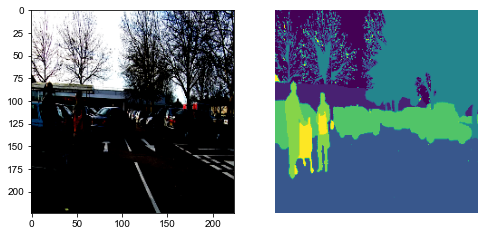

In [37]:
# 直接通过单通道灰度图展示
for images, annots in train.take(1):
    plt.figure(figsize=(8,5))
    plt.subplot(1,2,1)
    plt.imshow(images[0])
    plt.subplot(1,2,2)
    plt.imshow(np.argmax(annots[0],axis=-1))
    plt.axis('off')

In [14]:
def assign_color(annot): #通过RGB三通道显示
    annot = np.argmax(annot, axis=-1) #(224,224,12)->(224,224)
    seg_img = np.zeros([annot.shape[0],annot.shape[1], 3]).astype('float') #画布，float为来后续计算
    for i in range(n_classes):
        segc = (annot == i) #遍历每个像素是否属于该类别
        seg_img[:,:,0] += segc*(color_map[i][0] * 255.0) #属于该类别的像素，全部更新颜色RGB
        seg_img[:,:,1] += segc*(color_map[i][1] * 255.0)
        seg_img[:,:,2] += segc*(color_map[i][2] * 255.0)
    seg_img=seg_img.astype('uint8') #(0-255)需要整数显示
    return seg_img

def plot_segmentation(dataset,n=2):
    val = dataset.unbatch().shuffle(BUFFER_SIZE)
    plt.figure(figsize=(15, 5))
    for i, (image, annot) in enumerate(val.take(n)):
        image, annot = image.numpy(), annot.numpy()
        seg_img = assign_color(annot)
        image = (image + 1)*127.5 #denormalize到(0,255)
        image = image.astype('uint8')
        combined = np.concatenate((image,seg_img),axis=1)
        plt.subplot(1, n,i+1)
        plt.imshow(combined) 
        plt.axis('off')

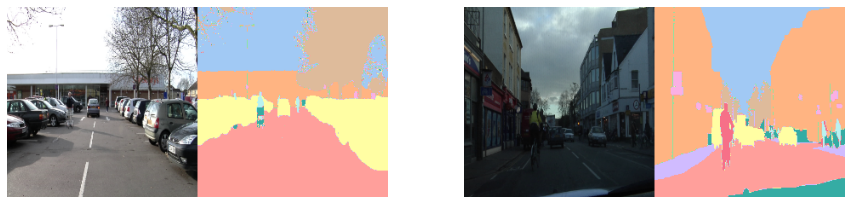

In [15]:
plot_segmentation(train,2)

#### TF Model
<img src='https://drive.google.com/uc?export=view&id=1lrqB4YegV8jXWNfyYAaeuFlwXIc54aRP' alt='fcn-8' style='height:300px;width:550px'>

**Encoder: VGG16**

In [12]:
# Tensorflow version
def block(inputs, block, n_convs, filters, kernel_size=3, activation='relu', pool_size=2, pool_stride=2):
    x = inputs
    for i in range(n_convs): #也可以换成Conv2D+BatchNorm+Relu
        x = layers.Conv2D(filters, kernel_size, activation=activation, padding='same', name=f'conv{block}_{i+1}')(x)
    x = layers.MaxPooling2D(pool_size, strides=pool_stride, name=f'pooling{block}')(x)
    return x

def VGG16_encoder(inputs, pretrained=False):
    x = block(inputs, '1', n_convs=2, filters=64) #(224,224)->(112,112)
    x = block(x, '2', n_convs=2, filters=128) #(112,112)->(56,56)
    x = block(x, '3', n_convs=3, filters=256) #(56,56)->(28,28)
    p3= x #保存每个block最后一层pooling输出的结果，作为后续decoder还原的inputs
    x = block(x, '4', n_convs=3, filters=512) #(28,28)->(14,14)
    p4= x
    x = block(x, '5', n_convs=3, filters=512) #(14,14)->(7,7)
    p5= x 
    
    vgg16 = keras.Model(inputs , p5)
    if pretrained:
        vgg16.load_weights(weight_path) #加载不包含FC层的vgg16 weights

    #在p5后，再额外加上两层conv提取特征，用c7来做decoder的upsampling
    #也可以加Dropout
    c6 = layers.Conv2D(4096, 7, activation='relu', padding='same', name="conv6")(p5)
    c7 = layers.Conv2D(4096, 1, activation='relu', padding='same', name="conv7")(c6)
    return (p3, p4, c7)

In [ ]:
vgg16_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
path = tf.keras.utils.get_file(
    fname=vgg16_weight_path,
    origin='https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    extract=False) 

**Decoder: FCN8**

In [4]:
def FCN8_decoder(convs, n_classes):
    #此处为方便用p5代替c7表示，原图没有额外padding，所以照p3-5的shape来crop反卷积结果
    (p3, p4, p5) = convs 
    
    #Upsampling还原n_input：n_output=(n_input+2p-f)/s+1
    x1 = layers.Conv2DTranspose(n_classes, kernel_size=4, strides=2, use_bias=False)(p5) #(7,7)->(16,16)
    #为了达到翻2倍效果，需要剪切多余的border (top_crop, bottom_crop), (left_crop, right_crop)，只有一个()默认h,w剪切一样
    x1 = layers.Cropping2D(cropping=(1,1))(x1) #(16,16)->(14,14)
    #得到和x1一样的channel
    x2 = layers.Conv2D(n_classes, kernel_size=1, activation='relu', padding='same')(p4) #(14,14)
    x = layers.Add()([x1, x2])

    x1 = layers.Conv2DTranspose(n_classes, kernel_size=4, strides=2, use_bias=False)(x) #(14,14)->(30,30)
    x1 = layers.Cropping2D(cropping=(1, 1))(x1) #(30,30)->(28,28)
    x2 = layers.Conv2D(n_classes, kernel_size=1, activation='relu', padding='same')(p3) #(28,28)
    x = layers.Add()([x1, x2])

    #还原原图大小
    x = layers.Conv2DTranspose(n_classes, kernel_size=16, strides=8, use_bias=False)(x) #(28,28)->(232,232)
    x = layers.Cropping2D(cropping=(4, 4))(x) #(232,232)->(224,224)
    x = layers.Activation('softmax')(x)
    return x

In [6]:
def FCN8():
    inputs = keras.Input(shape=(224,224,3))
    convs = VGG16_encoder(inputs, vgg16_weight_path)
    outputs = FCN8_decoder(convs, n_classes)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
model = FCN8()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool2 (MaxPooling2D)     (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [280]:
steps_per_epoch = n_train//BATCH_SIZE
validation_steps = n_test//BATCH_SIZE

In [25]:
model.compile(loss='categorical_crossentropy',  #因为output是把每个class的概率都输出 one-hot
              optimizer=keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

history = model.fit(train, steps_per_epoch=steps_per_epoch, 
                    validation_data=validation, validation_steps=validation_steps, 
                    epochs=170)

Epoch 1/170
5/5 [==============================] - 61s 12s/step - loss: 2.7495 - accuracy: 0.0857 - val_loss: 2.4935 - val_accuracy: 0.0890
Epoch 2/170
5/5 [==============================] - 59s 12s/step - loss: 2.4892 - accuracy: 0.0879 - val_loss: 2.4861 - val_accuracy: 0.0895
Epoch 3/170
5/5 [==============================] - 55s 11s/step - loss: 2.4857 - accuracy: 0.0882 - val_loss: 2.4851 - val_accuracy: 0.0917
Epoch 4/170
5/5 [==============================] - 56s 11s/step - loss: 2.4847 - accuracy: 0.0919 - val_loss: 2.4843 - val_accuracy: 0.0940
Epoch 5/170
5/5 [==============================] - 57s 11s/step - loss: 2.4839 - accuracy: 0.0949 - val_loss: 2.4837 - val_accuracy: 0.0945
Epoch 6/170
5/5 [==============================] - 58s 12s/step - loss: 2.4832 - accuracy: 0.0971 - val_loss: 2.4831 - val_accuracy: 0.0951
Epoch 7/170
5/5 [==============================] - 59s 12s/step - loss: 2.4825 - accuracy: 0.0985 - val_loss: 2.4823 - val_accuracy: 0.0963
Epoch 8/170
5/5 [===

#### Pytorch Model

**Encoder**

In [ ]:
class Conv(nn.Module):
    def __init__(self, in_ch, filters, kernel_size=3, padding=1):
        super(Conv, self).__init__()
        self.conv = nn.Conv2d(in_ch, filters, kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(filters) 
        self.relu = nn.ReLU(inplace=True)

    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        return x  

class Block(nn.Module): #或者定义为encoder的函数
    def __init__(self, n_convs, in_ch, filters, pool_size=2, pool_stride=2):
        super(Block, self).__init__()
        block = []
        for i in range(n_convs): 
            block.append(Conv(in_ch, filters)) #以循环的部分为整体处理才不会出错，因此需要定义两个class
            in_ch = filters
        block.append(nn.MaxPool2d(pool_size, stride=pool_stride))
        self.block = nn.Sequential(*block)
        
    def forward(self, inputs):
        x = self.block(inputs)
        return x

class VGG16_encoder(nn.Module):
    def __init__(self, n_classes):
        super(VGG16_encoder,self).__init__() #(224,224)
        self.c0 = Conv(3, 64, padding=100) #padding版本，把第一层的第一个Conv改了 (422,422)
        self.p1 = Block(n_convs=1, in_ch=64, filters=64) #(211,211)
        self.p2 = Block(n_convs=2, in_ch=64, filters=128) #(105,105)
        self.p3 = Block(n_convs=3, in_ch=128, filters=256) #(52,52)
        self.p4 = Block(n_convs=3, in_ch=256, filters=512) #(26,26)
        self.p5 = Block(n_convs=3, in_ch=512, filters=512) #(13,13)
        
        self.c6 = nn.Sequential(
            nn.Conv2d(512, 4096, 7), #(7,7)
            nn.ReLU(inplace=True),
            nn.Dropout2d())
        self.c7 = nn.Sequential(
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout2d())
        self.output = nn.Conv2d(4096, n_classes, kernel_size=1)
            
    def forward(self, inputs):
        c0 = self.c0(inputs)
        p1=self.p1(c0)
        p2= self.p2(p1)
        p3 = self.p3(p2)
        p4 = self.p4(p3)
        p5 = self.p5(p4)
        c6 = self.c6(p5)
        c7 = self.c7(c6)
        output = self.output(c7)
        
    def load_pretrained(self, model_path):
        #pretrained_model = vgg16(pretrained=True)
        #pretrained_params = pretrained_model.state_dict() #预训练参数
        pretrained_params = torch.load(model_path).state_dict()
        keys = list(pretrained_params.keys())
        new_dict = {}
        for index, key in enumerate(self.state_dict().keys()): #本模型参数
            new_dict[key] = pretrained_params[keys[index]] #由于命名不同，但是每层顺序相同，用index取对应预训练参数
        self.load_state_dict(new_dict) #加载
        return (p3, p4, output)

In [51]:
model = VGG16_encoder(12)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 422, 422]           1,792
       BatchNorm2d-2         [-1, 64, 422, 422]             128
              ReLU-3         [-1, 64, 422, 422]               0
              Conv-4         [-1, 64, 422, 422]               0
            Conv2d-5         [-1, 64, 422, 422]          36,928
       BatchNorm2d-6         [-1, 64, 422, 422]             128
              ReLU-7         [-1, 64, 422, 422]               0
              Conv-8         [-1, 64, 422, 422]               0
         MaxPool2d-9         [-1, 64, 211, 211]               0
            Block-10         [-1, 64, 211, 211]               0
           Conv2d-11        [-1, 128, 211, 211]          73,856
      BatchNorm2d-12        [-1, 128, 211, 211]             256
             ReLU-13        [-1, 128, 211, 211]               0
             Conv-14        [-1, 128, 2

**Decoder**

In [4]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    center = kernel_size / 2 - 0.5
    row, col = np.ogrid[:kernel_size, :kernel_size] #(k,1)和(1,k)数组列表
    filt = (1 - abs(row - center) / factor) * (1 - abs(col - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

class FCN8_decoder(nn.Module):
    def __init__(self, n_classes):
        super(FCN8_decoder, self).__init__() 
        #由于原图有padding变大，所以这里是把pooling的结果crop来配合反卷积的结果
        self.convt1 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=2, bias=False)
        self.conv1 = nn.Sequential(
            nn.Conv2d(512, n_classes, kernel_size=1), 
            nn.ReLU(inplace=True))
        self.convt2 = nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=2, bias=False)
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, n_classes, kernel_size=1), 
            nn.ReLU(inplace=True))
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(n_classes, n_classes, kernel_size=16, stride=8, bias=False),
            nn.Softmax())
        
        # 初始化参数
        for layer in self.modules():
            if isinstance(layer, nn.ConvTranspose2d):
                layer.weight.data = bilinear_kernel(n_classes, n_classes, layer.kernel_size[0])
        
    def forward(self, p3, p4, c7):
        #Upsampling还原
        x1 = self.convt1(c7) #(7,7)->(16,16)
        x2 = self.conv1(p4) #(26,26)
        x2 = transforms.CenterCrop((x1.size(2),x1.size(3)))(x2) #(16,16)
        x = x1 + x2
        
        x1 = self.convt2(x) #(16,16)->(34,34)
        x2 = self.conv2(p3) #(52,52)
        x2 = transforms.CenterCrop((x1.size(2),x1.size(3)))(x2) #(34,34)
        x = x1 + x2

        #还原原图大小
        x = self.convt3(x) #(34,34)->(280,280)
        x = transforms.CenterCrop((224,224))(x) #(224,224)
        return x

In [5]:
class FCN8(nn.Module):
    def __init__(self, n_classes):
        super(FCN8, self).__init__()
        self.encoder = VGG16_encoder(n_classes)
        self.decoder = FCN8_decoder(n_classes)
        
    def forward(self, inputs):
        p3, p4, c7 = self.encoder(inputs)
        outputs = self.decoder(p3, p4, c7)
        return outputs

In [11]:
# 没有padding版本
model = FCN8(n_classes = 12)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
              Conv-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
              ReLU-5         [-1, 64, 224, 224]               0
              Conv-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
             Block-8         [-1, 64, 112, 112]               0
            Conv2d-9        [-1, 128, 112, 112]          73,856
             ReLU-10        [-1, 128, 112, 112]               0
             Conv-11        [-1, 128, 112, 112]               0
           Conv2d-12        [-1, 128, 112, 112]         147,584
             ReLU-13        [-1, 128, 112, 112]               0
             Conv-14        [-1, 128, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [10]:
# 有padding版本
model = FCN8(n_classes = 21)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 422, 422]           1,792
       BatchNorm2d-2         [-1, 64, 422, 422]             128
              ReLU-3         [-1, 64, 422, 422]               0
              Conv-4         [-1, 64, 422, 422]               0
            Conv2d-5         [-1, 64, 422, 422]          36,928
       BatchNorm2d-6         [-1, 64, 422, 422]             128
              ReLU-7         [-1, 64, 422, 422]               0
              Conv-8         [-1, 64, 422, 422]               0
         MaxPool2d-9         [-1, 64, 211, 211]               0
            Block-10         [-1, 64, 211, 211]               0
           Conv2d-11        [-1, 128, 211, 211]          73,856
      BatchNorm2d-12        [-1, 128, 211, 211]             256
             ReLU-13        [-1, 128, 211, 211]               0
             Conv-14        [-1, 128, 2

#### Evaluation

In [63]:
def plot_metrics(history, string):
    plt.plot(history.history[string],label=string)
    plt.plot(history.history['val_'+string],label='val_'+string)
    plt.xlabel("Epochs")
    plt.title(string.capitalize())
    plt.legend()
    plt.show()

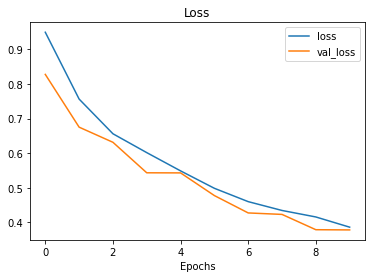

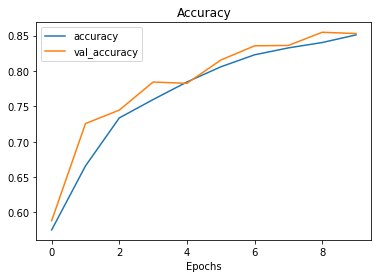

In [25]:
plot_metrics(history, "loss")
plot_metrics(history, 'accuracy')

$$IOU = \frac{Intersection}{Union}$$
$$Dice Score = 2 * \frac{Intersection}{Combined\_area}$$

In [63]:
#计算每个类别的iou和dice_score
def iou_and_dice_score(y_true, y_pred, smoothing_factor = 1e-10):
    class_iou = [] #帮助了解最差的情况
    class_dice_score = [] #更偏向平均情况
    
    for i in range(n_classes): 
        intersection = np.sum((y_pred == i) * (y_true == i)) #判断每个像素的类别，预测正确时才能相乘为1，求和
        y_true_area = np.sum((y_true == i))
        y_pred_area = np.sum((y_pred == i))
        combined_area = y_true_area + y_pred_area
        union = combined_area - intersection

        iou = (intersection + smoothing_factor) / (union + smoothing_factor)
        class_iou.append(iou)

        dice_score =  2 * ((intersection + smoothing_factor) / (combined_area + smoothing_factor))
        class_dice_score.append(dice_score)

    return class_iou, class_dice_score

In [64]:
def plot_prediction(dataset,batch_size, n):
    val = dataset.unbatch().batch(batch_size) 
    for (images, annots) in val.take(1):
        y_true = np.argmax(annot, axis=-1) #(m,224,224)
        y_pred = model.predict(images[n][tf.newaxis,...]) #为减少运算量，只预测一张图(1,224,224,3)，否则也可以predict(val, steps=validation_steps)
        y_pred = np.argmax(y_pred, axis=-1) #(1,224,224)
        image, y_true, y_pred = images[n].numpy(), y_true[n].numpy(), y_pred[0].numpy()
        
    # 对比图片
    seg_img_true = assign_color(y_true)
    seg_img_pred = assign_color(y_pred)
    image = (image + 1)*127.5 #denormalize到(0,255)
    image = image.astype('uint8')
    images = [image, seg_img_true, seg_img_pred]
    titles = ['Image','True Mask','Predicted Mask']
    plt.figure(figsize=(15, 4))
    for i, image in enumerate(images):
        plt.subplot(1,3,i+1)
        plt.imshow(image) 
        plt.title(titles[i])
        plt.axis('off')
    
    # 这张图片的metric
    class_iou, class_dice_score = iou_and_dice_score(y_true, y_pred)
    metrics = pd.DataFrame({'Class':class_names,'IOU':class_iou,'Dice Score':class_dice_score})
    metrics = metrics.sort_values(['IOU','Dice Score'], ascending=False)
    print(metrics)

In [ ]:
n = np.random.choice(n_test)
plot_prediction(test, n_test, n)